# 第05章: 05 Tree And Ensemble Models

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    AdaBoostClassifier, BaggingClassifier
)
from sklearn.metrics import accuracy_score, mean_squared_error

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Part 1: Decision Tree Fundamentals

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate simple data
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

print(f"Training accuracy: {tree.score(X_train, y_train):.4f}")
print(f"Test accuracy: {tree.score(X_test, y_test):.4f}")

Training accuracy: 0.9125
Test accuracy: 0.9333


**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

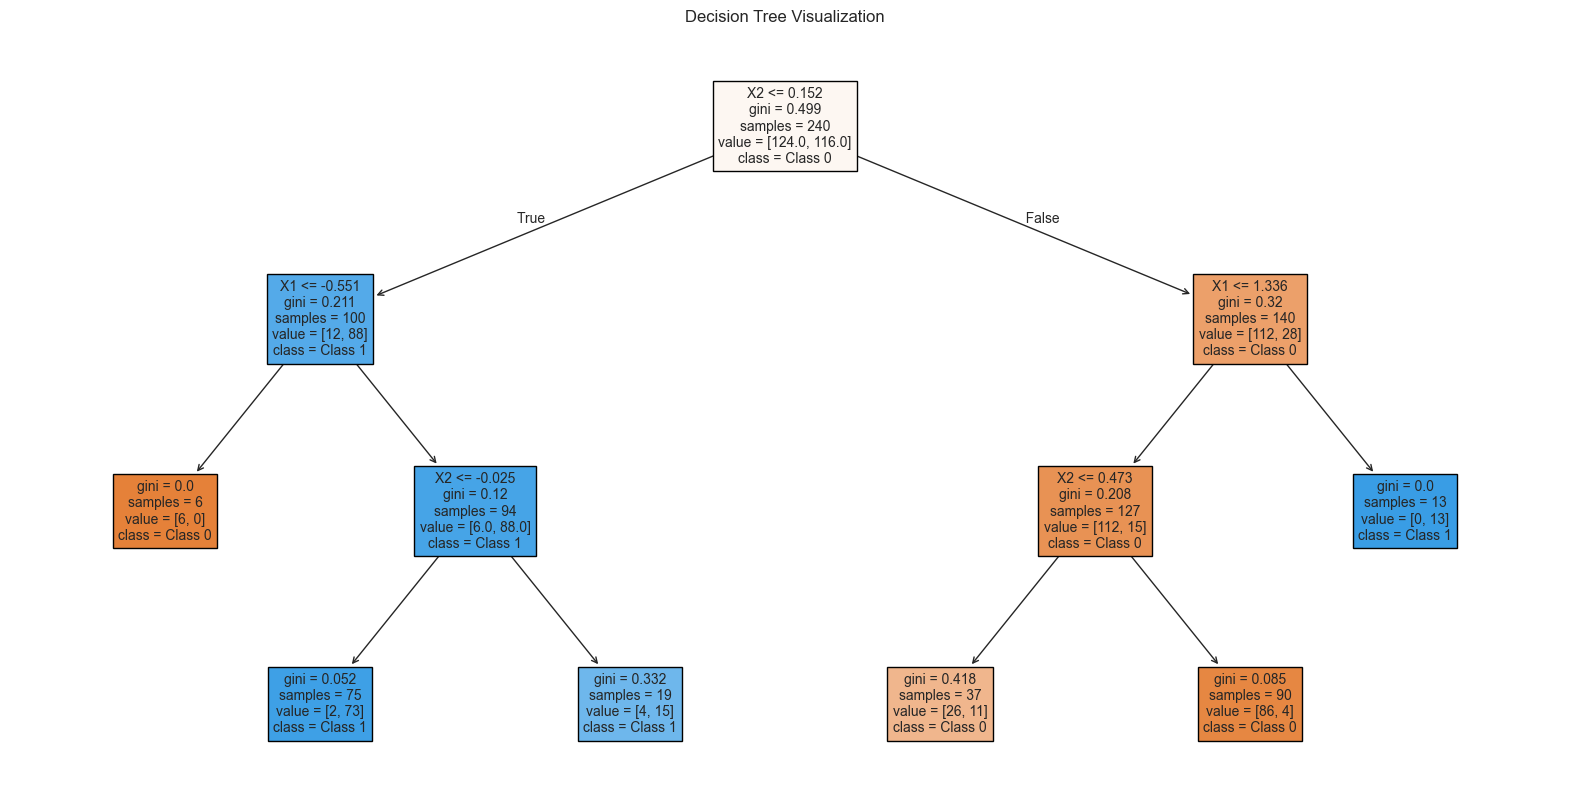

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=['X1', 'X2'], 
          class_names=['Class 0', 'Class 1'], fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

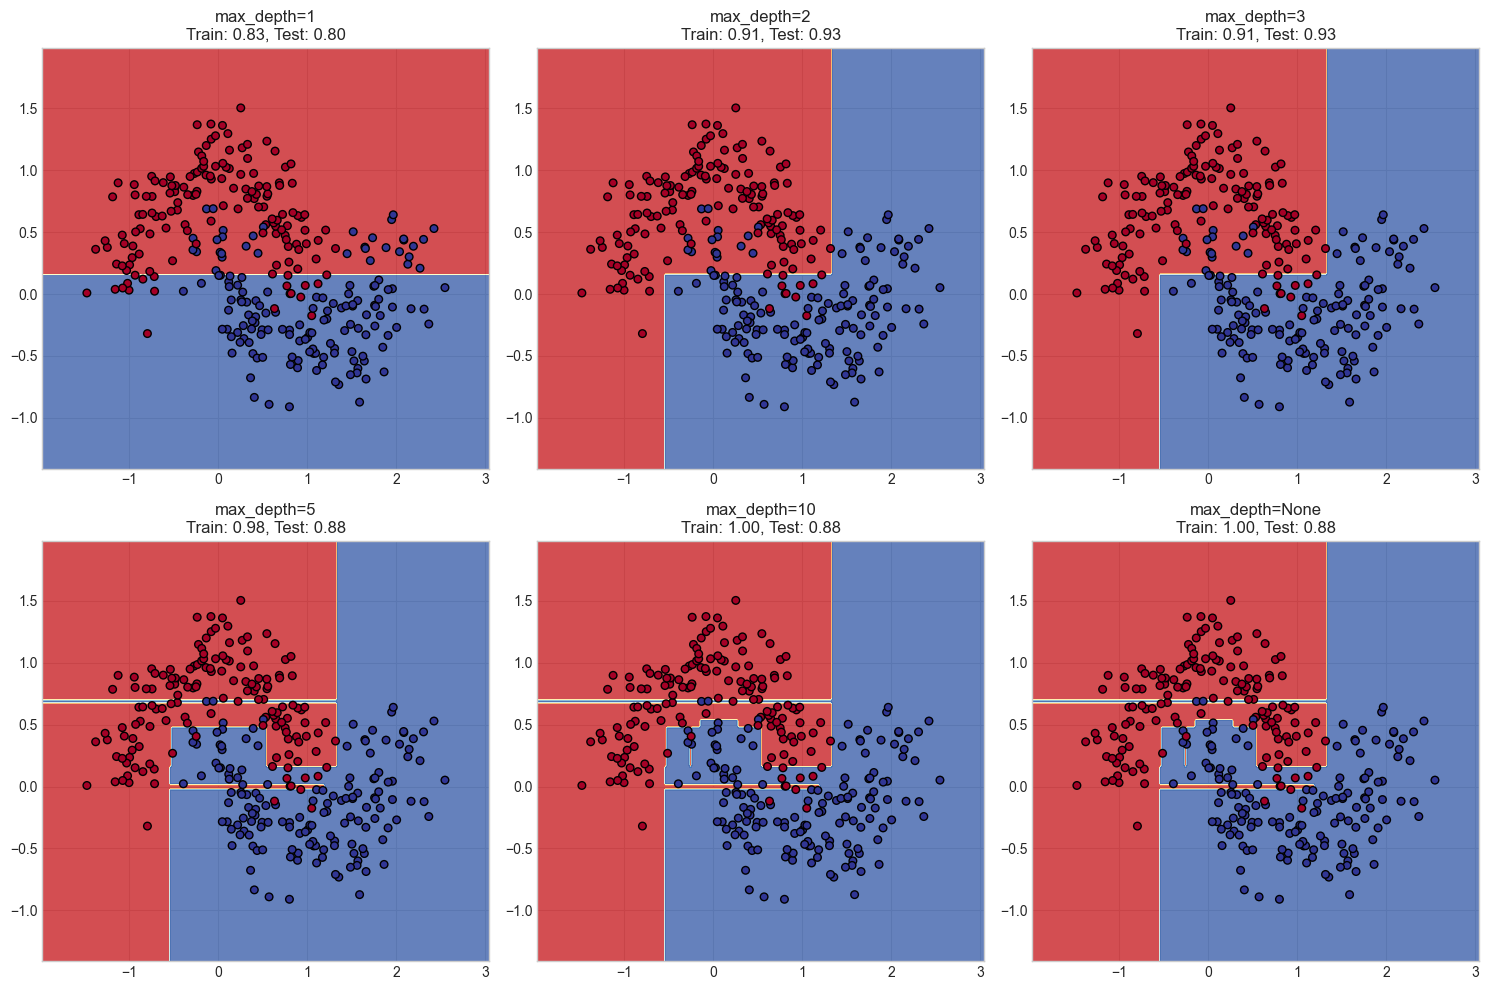

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Decision boundary function
def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
    ax.set_title(title)

# Compare different max_depth values
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

depths = [1, 2, 3, 5, 10, None]

for idx, depth in enumerate(depths):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    depth_str = str(depth) if depth else 'None'
    plot_decision_boundary(tree, X, y, axes[idx], 
                          f'max_depth={depth_str}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}')

plt.tight_layout()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

## Part 2: Tree Hyperparameters

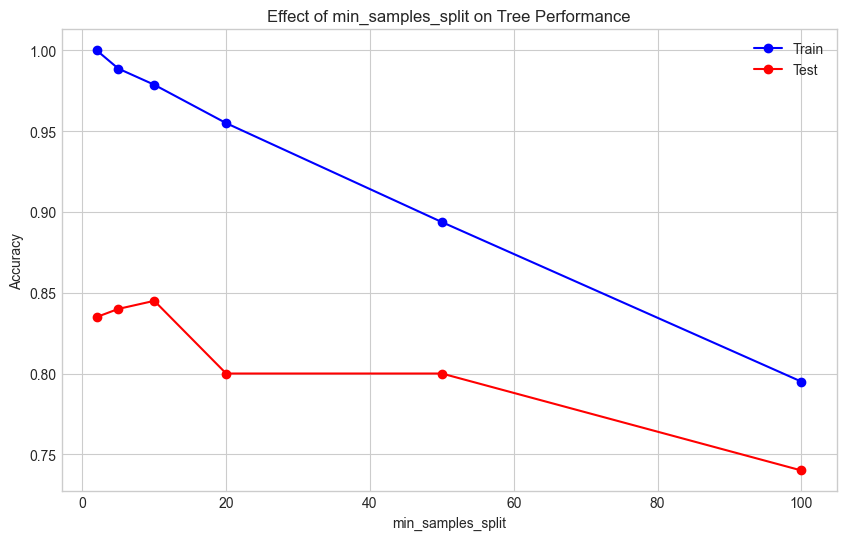

In [5]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate more complex data
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Explore min_samples_split
min_samples_values = [2, 5, 10, 20, 50, 100]

train_scores = []
test_scores = []

for min_samples in min_samples_values:
    tree = DecisionTreeClassifier(min_samples_split=min_samples, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, train_scores, 'bo-', label='Train')
plt.plot(min_samples_values, test_scores, 'ro-', label='Test')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_split on Tree Performance')
plt.legend()
plt.grid(True)
plt.show()

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Grid search for optimal tree parameters
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {grid_search.best_score_:.4f}")
print(f"Test score: {grid_search.score(X_test, y_test):.4f}")

Best parameters:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 5

Best CV score: 0.8463
Test score: 0.8400


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 3: Random Forest

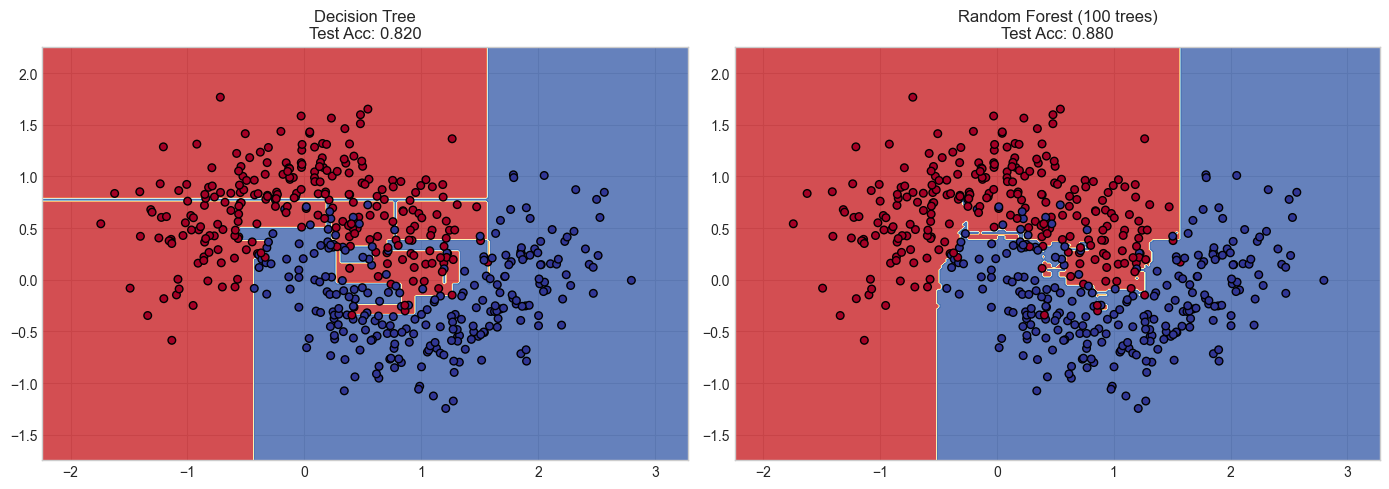

In [7]:
# Compare single tree vs random forest
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Single tree
tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

# Random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_decision_boundary(tree, X, y, axes[0], 
                      f'Decision Tree\nTest Acc: {tree.score(X_test, y_test):.3f}')
plot_decision_boundary(rf, X, y, axes[1], 
                      f'Random Forest (100 trees)\nTest Acc: {rf.score(X_test, y_test):.3f}')

plt.tight_layout()
plt.show()

**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


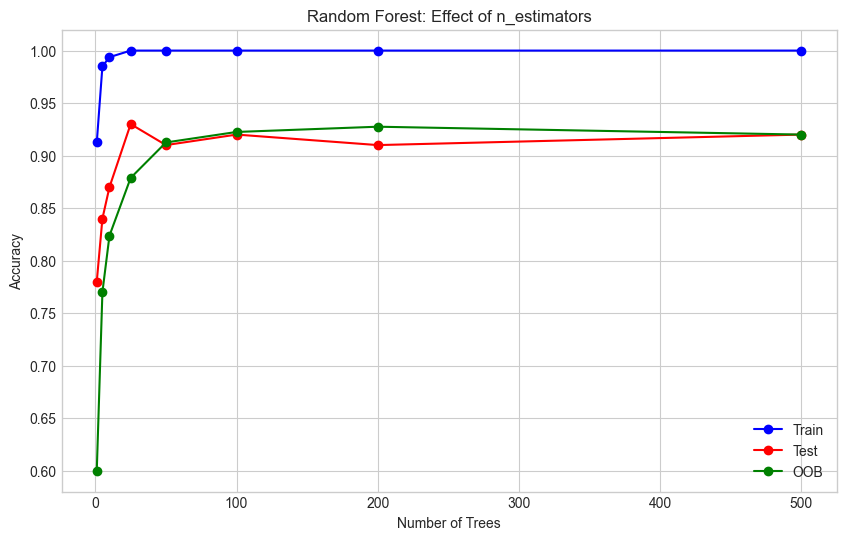

In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Effect of n_estimators
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10,
    n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators_range = [1, 5, 10, 25, 50, 100, 200, 500]

train_scores = []
test_scores = []
oob_scores = []

for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, oob_score=True, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'bo-', label='Train')
plt.plot(n_estimators_range, test_scores, 'ro-', label='Test')
plt.plot(n_estimators_range, oob_scores, 'go-', label='OOB')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest: Effect of n_estimators')
plt.legend()
plt.grid(True)
plt.show()

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Effect of max_features
max_features_options = ['sqrt', 'log2', 0.3, 0.5, 0.7, 1.0]

results = []

for max_feat in max_features_options:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_feat, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    results.append({
        'max_features': str(max_feat),
        'train_acc': rf.score(X_train, y_train),
        'test_acc': rf.score(X_test, y_test)
    })

df_results = pd.DataFrame(results)
print("Effect of max_features:")
print(df_results.to_string(index=False))

Effect of max_features:
max_features  train_acc  test_acc
        sqrt        1.0     0.920
        log2        1.0     0.920
         0.3        1.0     0.930
         0.5        1.0     0.895
         0.7        1.0     0.915
         1.0        1.0     0.900


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 4: Feature Importance

#### 📦 必要なライブラリの読み込み

このセクションでは、分析に必要なPythonライブラリを読み込みます。

**主要ライブラリの役割**：
- **NumPy**: 数値計算の基盤（配列操作、数学関数）
- **Pandas**: データ操作と分析（表形式データの処理）
- **Matplotlib / Seaborn**: データ可視化（グラフ作成）
- **scikit-learn**: 機械学習アルゴリズムとツール

ライブラリのインポートは、プログラムの最初に一度だけ行います。
これにより、以降のコードでこれらの機能を使用できるようになります。

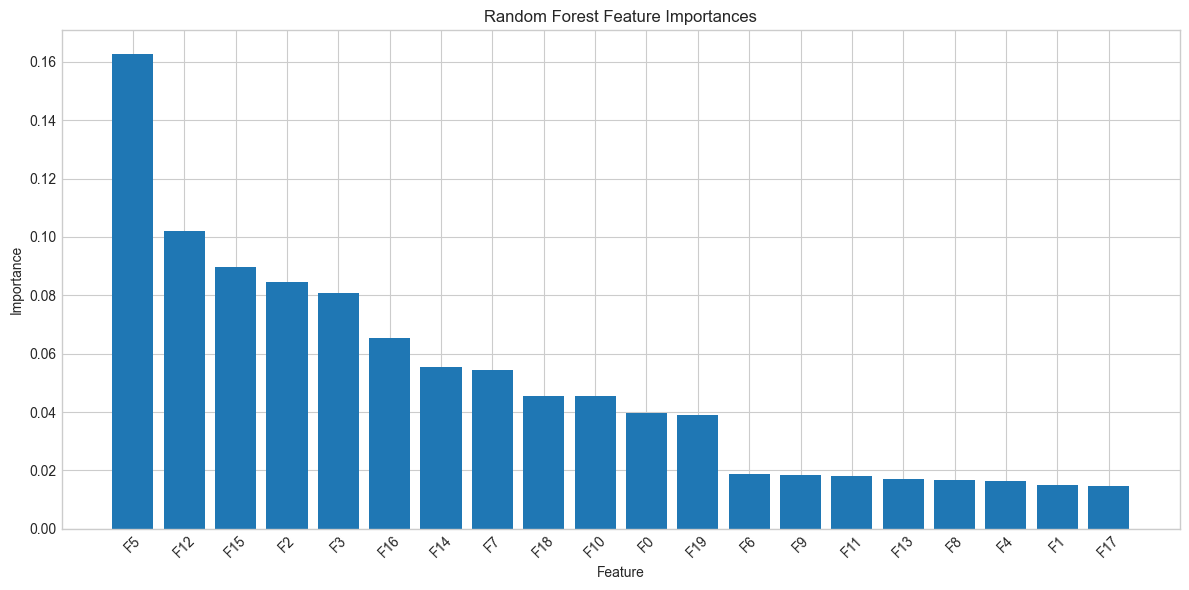

Top 10 most important features:
  Feature 5: 0.1626
  Feature 12: 0.1021
  Feature 15: 0.0898
  Feature 2: 0.0847
  Feature 3: 0.0807
  Feature 16: 0.0652
  Feature 14: 0.0555
  Feature 7: 0.0546
  Feature 18: 0.0455
  Feature 10: 0.0454


In [10]:
# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [f'F{i}' for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
for i in range(10):
    print(f"  Feature {indices[i]}: {importances[indices[i]]:.4f}")

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

## Part 5: Gradient Boosting

In [11]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare Random Forest vs Gradient Boosting
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}

print("Ensemble Methods Comparison:")
print("="*50)

for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Ensemble Methods Comparison:

Random Forest:
  Train Accuracy: 1.0000
  Test Accuracy: 0.9200
  CV Score: 0.9262 (+/- 0.0366)

Gradient Boosting:
  Train Accuracy: 0.9962
  Test Accuracy: 0.9300
  CV Score: 0.9200 (+/- 0.0436)

AdaBoost:
  Train Accuracy: 0.9275
  Test Accuracy: 0.8600
  CV Score: 0.8475 (+/- 0.0376)


**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

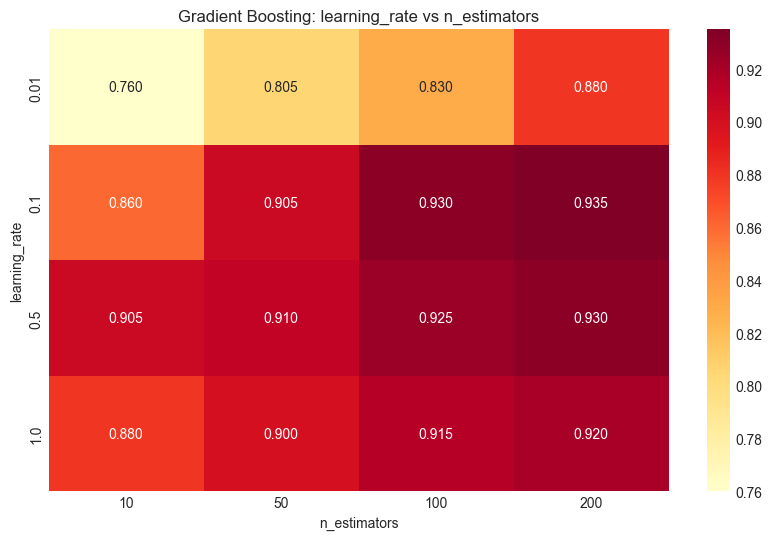

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Gradient Boosting: learning_rate vs n_estimators tradeoff
learning_rates = [0.01, 0.1, 0.5, 1.0]
n_estimators_range = [10, 50, 100, 200]

results = []

for lr in learning_rates:
    for n_est in n_estimators_range:
        gb = GradientBoostingClassifier(
            learning_rate=lr, n_estimators=n_est, random_state=42
        )
        gb.fit(X_train, y_train)
        
        results.append({
            'learning_rate': lr,
            'n_estimators': n_est,
            'test_acc': gb.score(X_test, y_test)
        })

# Create heatmap
df_results = pd.DataFrame(results)
pivot = df_results.pivot(index='learning_rate', columns='n_estimators', values='test_acc')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Gradient Boosting: learning_rate vs n_estimators')
plt.show()

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

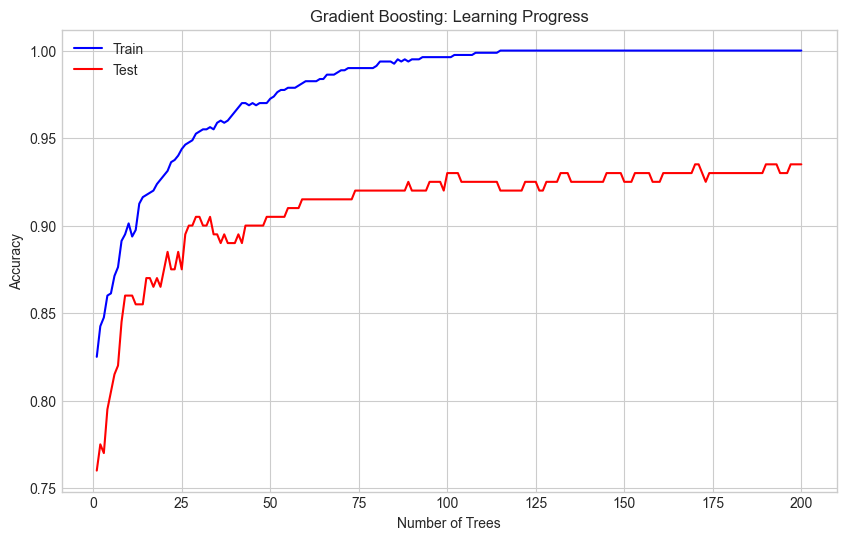

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Staged predictions - see how GB improves with more trees
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# Get staged predictions
train_scores_staged = []
test_scores_staged = []

for i, y_pred in enumerate(gb.staged_predict(X_train)):
    train_scores_staged.append(accuracy_score(y_train, y_pred))

for i, y_pred in enumerate(gb.staged_predict(X_test)):
    test_scores_staged.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores_staged) + 1), train_scores_staged, 'b-', label='Train')
plt.plot(range(1, len(test_scores_staged) + 1), test_scores_staged, 'r-', label='Test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Learning Progress')
plt.legend()
plt.grid(True)
plt.show()

**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 6: Regression with Trees

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate regression data
X, y = make_regression(n_samples=500, n_features=10, n_informative=5, noise=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compare models
from sklearn.metrics import r2_score

models_reg = {
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("Regression Models Comparison:")
print("="*50)

for name, model in models_reg.items():
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")

Regression Models Comparison:

Decision Tree:
  Train R²: 0.9967
  Test R²: 0.5815

Random Forest:
  Train R²: 0.9684
  Test R²: 0.7812

Gradient Boosting:
  Train R²: 0.9738
  Test R²: 0.8377


**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

## Part 7: Bagging vs Boosting Visualization

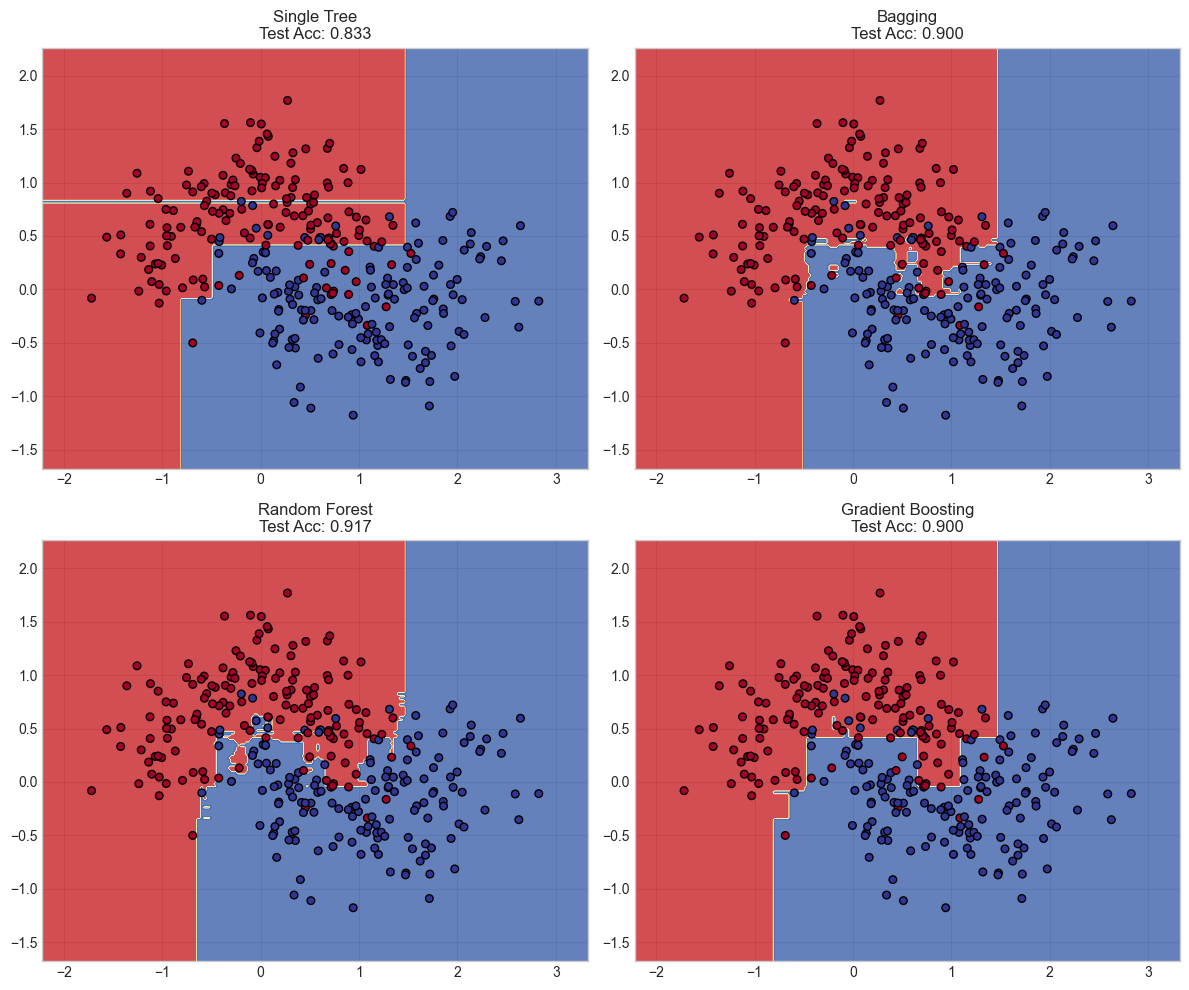

In [15]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare decision boundaries
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models_compare = {
    'Single Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models_compare.items()):
    model.fit(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    plot_decision_boundary(model, X, y, axes[idx], f'{name}\nTest Acc: {test_acc:.3f}')

plt.tight_layout()
plt.show()

**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

## Part 8: Hyperparameter Tuning for Random Forest

In [16]:
# ============================================================
# [コードの説明]
# ============================================================

# Grid search for Random Forest
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score: {grid_search_rf.best_score_:.4f}")
print(f"Test Score: {grid_search_rf.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Random Forest Parameters:
  max_depth: 10
  max_features: sqrt
  min_samples_split: 2
  n_estimators: 200

Best CV Score: 0.9287
Test Score: 0.9200


**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Summary

In this notebook, you learned:

### Decision Trees
- Tree structure and splitting criteria
- Key parameters: max_depth, min_samples_split, min_samples_leaf
- Prone to overfitting without constraints

### Ensemble Methods
- **Bagging**: Reduce variance, parallel training
- **Random Forest**: Bagging + feature randomization
- **Boosting**: Reduce bias, sequential training
- **Gradient Boosting**: Most powerful, careful tuning needed

### Key Parameters
- n_estimators: More trees = better (with diminishing returns)
- max_features: Controls diversity in Random Forest
- learning_rate: Controls step size in Boosting

### Key Takeaways
- Ensembles almost always outperform single trees
- Random Forest is robust and easy to tune
- Gradient Boosting often achieves best performance
- Feature importance helps interpretability

### Next Steps
Continue to **Notebook 06** for SVM and kernel methods.

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
